# Pose Prediction

In [1]:
%matplotlib notebook
%pylab

from __future__ import print_function
from __future__ import division

import csv
import os
import itertools

import numpy as np
import tensorflow as tf

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation

tf.logging.set_verbosity(tf.logging.INFO)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Visualizing the input data

<IPython.core.display.Javascript object>


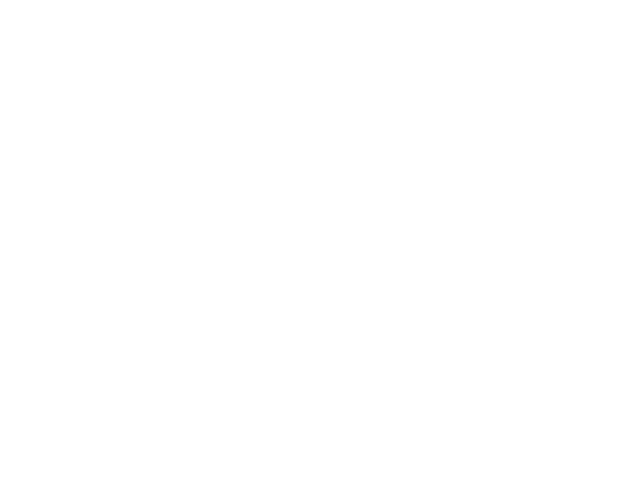

In [2]:
data = {
    'x': [],
    'y': [],
    'z': []
}

feature_names = [
  'headX', 'headY', 'headZ',
  'scX', 'scY', 'scZ', # Shoulder center
  'slX', 'slY', 'slZ', # Shoulder left
  'srX', 'srY', 'srZ', # Shoulder right
  'elX', 'elY', 'elZ', # Elbow left
  'erX', 'erY', 'erZ'  # Elbow right
]
feature_columns = [tf.feature_column.numeric_column(feature_name) for feature_name in feature_names]
n_features = len(feature_names)
n_keypoints = n_features // 3

with open('record.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',', quotechar='"')
  next(reader) #skip first line

  for row in reader:
    data['x'].append([float(row[3*i]) for i in range(n_keypoints)])
    data['y'].append([float(row[3*i + 1]) for i in range(n_keypoints)])
    data['z'].append([float(row[3*i + 2]) for i in range(n_keypoints)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
graph = ax.scatter(data['x'][0], data['z'][0], data['y'][0])

# Setting the axes properties
ax.set_xlim3d([-0.5, 0.5])
ax.set_xlabel('X')

ax.set_ylim3d([1.0, 2.0])
ax.set_ylabel('Z')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Y')

def animate(i):
    graph._offsets3d = (data['x'][i], data['z'][i], data['y'][i])
    
anim = animation.FuncAnimation(fig, animate, 400, interval=40, blit=False)

plt.show()

## Learning

### Data pre-processing
This defines an `input_fn` for `tf.estimator` functions. See [Building input functions with `tf.estimator`](https://www.tensorflow.org/get_started/input_fn).

In [6]:
batch_size = 20
time_steps = 10

def get_input(file_path):
  """Reads a CSV timeseries of keypoints and returns a `features`, `labels` pair.
  
  Args:
    file_path: string of the file to read
  Returns:
    features: TF iterator of Dict<feature_name, Tensor(feature_value)>
    labels: TF iterator of Tensor(labels) (which are the coordinates of the keypoints in the next frame)
  """
  def decode_csv(line, as_dict=False):
    parsed_line = tf.decode_csv(line, [
      [0.], [0.], [0.],
      [0.], [0.], [0.],
      [0.], [0.], [0.],
      [0.], [0.], [0.],
      [0.], [0.], [0.],
      [0.], [0.], [0.]])

    if as_dict:
      return dict(zip(feature_names, parsed_line))
    else:
      return tf.squeeze(parsed_line)

  raw_data = tf.data.TextLineDataset(file_path).skip(1)
  x = raw_data.map(lambda x: decode_csv(x, as_dict=True))
  y = raw_data.map(lambda x: decode_csv(x, as_dict=False)).skip(1)

  dataset = tf.data.Dataset.zip((x, y)).repeat().batch(batch_size * time_steps)
  features, labels = dataset.make_one_shot_iterator().get_next()
  return features, labels

### Parse the data

In [5]:
import common.config_utils

# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

FILTERED_NAMES = [
  'Spine',
  'Thorax',
  'Neck/Nose',
  'Head',
  'LShoulder',
  'LElbow',
  'LWrist',
  'RShoulder',
  'RElbow',
  'RWrist'
]

FILTERED_INDICES = [i for i, s in enumerate(H36M_NAMES) if s in FILTERED_NAMES]

def create_vocab(clips):
  subtitles = map(lambda clip: clip['subtitle'], clips)
  
  unique_chars = set()
  for sentence in subtitles:
    unique_chars = unique_chars | set(sentence)
  
  unique_chars = list(unique_chars)
  vocab_size = len(unique_chars)
  vocab_index_dict = {'¶': 0} # Terminator character
  index_vocab_dict = {0: '¶'}
  
  for i, char in enumerate(unique_chars):
      vocab_index_dict[char] = i
      index_vocab_dict[i] = char
  return vocab_index_dict, index_vocab_dict, vocab_size

def char2feature(char, vocab):
  index = vocab[char]
  return np.eye(len(vocab))[char]

def subtitle2features(subtitle, vocab):
  indices = [vocab[char] for char in subtitle] + [0] # Append terminator
  return np.eye(len(vocab))[np.array(indices).flatten()]
  
def poses2labels(poses):
  poses = np.array(poses)[:, FILTERED_INDICES, :]
  poses = np.reshape(poses, (-1, len(FILTERED_INDICES) * 3))

  return poses.tolist()

def pad_features(features, vocab, n):
  return np.append(
    features, 
    np.repeat([char2feature('¶', vocab)], n, axis=0), 
    axis=0)

def get_label_masks(labels, n):
  #    n * [0] ("not started")
  # ++ len(labels) * [1] ("look at me")
  # ++ 1 * [0] ("terminated")
  return np.append(
    np.zeros((n, 1)),
    np.ones((labels.shape[0], 1)),
    no.zeros((1, 1))
    axis=0
  )

def pad_labels(labels, n):
  # This will set the terminator label to 1
  # The rest of the values don't matter then
  return np.insert(labels, np.ones((n, labels.shape[1])), axis=0)

def clip2sample(clip, vocab):
  subtitle = clip['subtitle']
  poses_3d = clip['poses_3d']

  features = subtitle2features(subtitle, vocab)
  features = pad_features(features, vocab, len(poses_3d))

  labels = poses2labels(poses_3d)
  label_masks = get_label_masks(labels, len(subtitle))
  labels = pad_labels(labels, len(subtitle))
  
  return (features, (label_masks, labels))

def create_examples(clips):
  vocab, _, _ = create_vocab(clips)
  return map(lambda clip: clip2sample(clip, vocab), clips)

### GAN Model

In [1]:
def generator(inputs):
  """Generator to produce realistic movement.
  
  Args:
    inputs: 2-tuple of Tensors (noise, subtitle)
  """

SyntaxError: unexpected EOF while parsing (<ipython-input-1-6d19ff1f7a68>, line 2)

### Model Setup

In [7]:
# Defining a simple RNN model
hidden_size = 128

def rnn_model_fn(features, labels, mode, params):
  """TensorFlow model function for an RNN

  Args:
    features: Dict<feature_name, Tensor(feature_value)>
    labels: Tensor(labels or targets)
    mode: a tf.estimator.ModeKeys indicating the context.
      One of tf.estimator.ModeKeys.{TRAIN,EVAL,PREDICT}
    params: a dict of other parameters
      feature_columns: a list of tf.FeatureColumn
      learning_rate
  """
  
  n_features = len(params.feature_columns)
  n_labels = n_features

  def _get_input_tensors(features, labels):
    """Converts the input dict into a feature and target tensor"""
    input_layer = tf.feature_column.input_layer(features, params.feature_columns)
    input_layer = tf.reshape(input_layer, [batch_size, time_steps, n_features])
    if labels is not None:
      labels = tf.reshape(labels, [batch_size, time_steps, n_features])
    return  input_layer, labels

  def _add_rnn_layers(inputs):
    """Adds RNN layers after inputs and returns output, state

    Args:
      inputs: Tensor[batch_size, max_time, ...]
      num_units: Size of the cell state (defaults to 128)
    Returns: Tensor[batch_size, max_time, num_units](Output)
    """
    cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
    initial_state = cell.zero_state(batch_size, tf.float32)
    output, _ = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state)
    return output

  def _add_fc_layers(final_state, output_size):
    """Add final dense layer to get the correct output size
    """
    return tf.layers.dense(final_state, output_size, activation=None)

  inputs, labels = _get_input_tensors(features, labels)
  final_state = _add_rnn_layers(inputs)
  output_layer = _add_fc_layers(final_state, n_labels)

  # predictions = tf.reshape(output_layer, [-1]) # Flatten

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=output_layer)
  
  # TODO: Should mask & compare output after terminator character,
  #       until terminator pose
  loss = tf.losses.mean_squared_error(labels, output_layer)

  optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate)
  train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())

  return tf.estimator.EstimatorSpec(
    mode=mode,
    predictions=output_layer,
    loss=loss,
    train_op=train_op)

### Learning

In [8]:
model_params = tf.contrib.training.HParams(
  feature_columns=feature_columns,
  learning_rate=0.0001)

run_config = tf.estimator.RunConfig(
  model_dir='models',
  save_checkpoints_secs=60,
  save_summary_steps=100)

estimator = tf.estimator.Estimator(
  model_fn=rnn_model_fn,
  config=run_config,
  params=model_params)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Using config: {'_session_config': None, '_save_checkpoints_secs': 60, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f58f23c0be0>, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_master': '', '_task_id': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_evaluation_master': '', '_save_summary_steps': 100, '_num_worker_replicas': 1, '_is_chief': True, '_model_dir': 'models', '_service': None}


In [9]:
estimator.train(lambda: get_input('record.csv'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into models/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.2491453
INFO:tensorflow:global_step/sec: 29.3462
INFO:tensorflow:step = 101, loss = 0.07398523 (3.408 sec)
INFO:tensorflow:global_step/sec: 29.4456
INFO:tensorflow:step = 201, loss = 0.03676805 (3.396 sec)
INFO:tensorflow:global_step/sec: 27.8419
INFO:tensorflow:step = 301, loss = 0.017046358 (3.592 sec)
INFO:tensorflow:global_step/sec: 27.2225
INFO:tensorflow:step = 401, loss = 0.012362137 (3.673 sec)
INFO:tensorflow:global_step/sec: 28.323
INFO:tensorflow:step = 501, loss = 0.010229503 (3.531 sec)
INFO:tensorflow:global_step/sec: 27.5724
INFO:tensorflow:step = 601, loss = 0.0032071702 (3.627 sec)
INFO:tensorflow:global_step/sec: 27.3257
INFO:tensorflow:

KeyboardInterrupt: 

In [15]:
predictions = estimator.predict(lambda: get_input('record.csv'))

# Map predictions to (x[], y[], z[])[] for visualisation
output = ((
    [i[j] for j in list(range(6))*3], 
    [i[j+1] for j in list(range(6))*3], 
    [i[j+2] for j in list(range(6))*3]) 
    for i in itertools.chain.from_iterable(predictions))

print(next(output))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Exception ignored in: <generator object Estimator.predict at 0x7f58c77886d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "/usr/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 5086, in get_controller
    yield g
  File "/usr/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects


([0.6197503, 0.006374558, 0.04165829, 0.3435234, 0.63513756, -0.2635693, 0.6197503, 0.006374558, 0.04165829, 0.3435234, 0.63513756, -0.2635693, 0.6197503, 0.006374558, 0.04165829, 0.3435234, 0.63513756, -0.2635693], [0.006374558, 0.04165829, 0.3435234, 0.63513756, -0.2635693, -0.41307244, 0.006374558, 0.04165829, 0.3435234, 0.63513756, -0.2635693, -0.41307244, 0.006374558, 0.04165829, 0.3435234, 0.63513756, -0.2635693, -0.41307244], [0.04165829, 0.3435234, 0.63513756, -0.2635693, -0.41307244, 0.99233013, 0.04165829, 0.3435234, 0.63513756, -0.2635693, -0.41307244, 0.99233013, 0.04165829, 0.3435234, 0.63513756, -0.2635693, -0.41307244, 0.99233013])


<IPython.core.display.Javascript object>


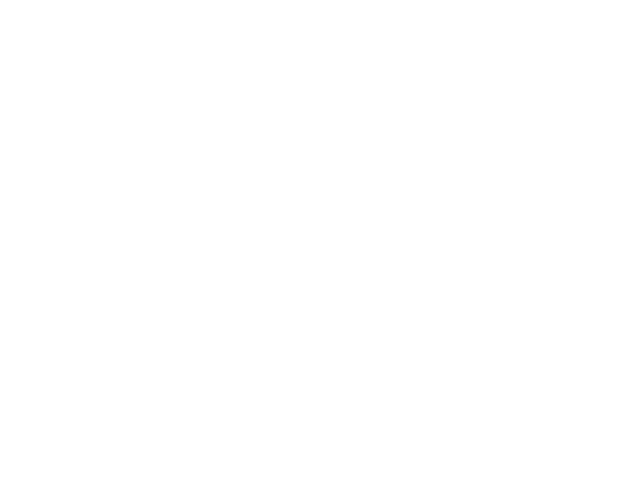

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

firstx, firsty, firstz = next(output)
graph = ax.scatter(firstx, firsty, firstz)

# Setting the axes properties
ax.set_xlim3d([-2, 2])
ax.set_xlabel('X')

ax.set_ylim3d([-2.0, 2.0])
ax.set_ylabel('Z')

ax.set_zlim3d([-2.0, 2.0])
ax.set_zlabel('Y')

def set_offsets(data):
  graph._offsets3d = data

n_seconds = 20
anim = animation.FuncAnimation(fig, set_offsets, frames=itertools.islice(output, 25*n_seconds), interval=40, blit=False)

In [464]:
plt.show()